In [261]:
import matplotlib.pyplot as plt
import numpy.random as rnd
import numpy as np
import io
import cv2
from matplotlib.patches import Ellipse
import itertools
import math

In [113]:
class Particle:
    
    def __init__(self, xy_pos, xy_vel):
        self.xy = xy_pos
        self.vel = xy_vel
        self.damp = 1.0
    
    def update(self):
        self.xy += self.vel
        

In [260]:
np.clip(np.array([0.3,0.3]),0.0,1.0)

array([0.3, 0.3])

0.18

In [312]:
class ParticleSystem:
    
    def __init__(self, start_count, env_size, part_size, rep_strength):
        self.parts = []
        self.part_size = part_size
        self.repel_strength = rep_strength
        self.lower_bound_x = 0
        self.lower_bound_y = 0
        self.upper_bound_x = env_size
        self.upper_bound_y = env_size
        self.sim_step = 0
        self.draw_step = 0
        self.init_parts(start_count)

    def init_parts(self, start_count):
        for _ in range(start_count):
            self.parts.append(
                Particle(
                    np.array([
                        rnd.random()*self.upper_bound_x, 
                        rnd.random()*self.upper_bound_y
                    ]),
                    np.array([0.0, 0.0])
                )
            )
        
    def pair_force(self, a, b):
        eps = 1.0
        dv = a.xy - b.xy
        dist = np.sqrt(dv.dot(dv))
        # spring-like linear force with k=repel_strength, l=part_size, m=1
        frc = (dv/dist)*self.repel_strength*max(self.part_size-dist,0.0)
        a.vel += frc
        b.vel -= frc
        
    def sim(self):
        for pair in itertools.combinations(self.parts, 2):
            self.pair_force(*pair)
        for part in self.parts:
            part.update()
            # walls
            xw = min(self.lower_bound_x+part.xy[0]-self.part_size, 0.0)
            part.vel[0] -= self.repel_strength*xw
            xw = min(self.upper_bound_x-part.xy[0]-self.part_size, 0.0)
            part.vel[0] += self.repel_strength*xw
            
            yw = min(self.lower_bound_y+part.xy[1]-self.part_size, 0.0)
            part.vel[1] -= self.repel_strength*yw
            yw = min(self.upper_bound_y-part.xy[1]-self.part_size, 0.0)
            part.vel[1] += self.repel_strength*yw
            
        self.sim_step += 1
            
    @staticmethod
    def get_img_from_fig(fig, dpi=180):
        '''
        graphics in python is really a sad state of affiars :'(
        from https://stackoverflow.com/a/58641662
        define a function which returns an image as numpy array from figure
        '''
        buf = io.BytesIO()
        fig.savefig(buf, format="png", dpi=dpi)
        buf.seek(0)
        img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
        buf.close()
        img = cv2.imdecode(img_arr, 1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        return img
    
    @staticmethod
    def hsv2rgb(c):
        '''
        iq's from https://www.shadertoy.com/view/lsS3Wc
        '''
        rgb = np.clip( np.abs(np.mod(c[0]*6.0+np.array([0.0,4.0,2.0]),6.0)-3.0)-1.0, 0.0, 1.0 )
        wht = np.array([1.0,1.0,1.0])
        return c[2] * (c[1]*rgb + (1.0-c[1])*wht)
        
    def draw(self):
        plt.close('all')
        ells = [(Ellipse(xy=[0.0,0.0],width=400,height=400), [0.0,0.0,0.0])]+[
            (Ellipse(
                xy=part.xy, 
                width=self.part_size, 
                height=self.part_size
            ),
            ParticleSystem.hsv2rgb([
                math.atan2(part.vel[0],part.vel[1]), 
                8.0*np.sqrt(part.vel.dot(part.vel)),
                0.9
            ]))
            for part in self.parts]

        fig = plt.figure(0)

        DPI = fig.get_dpi()
        fig.set_size_inches(dim_size/float(DPI),dim_size/float(DPI))

        ax = fig.add_subplot(111, aspect='equal')
        for e,col in ells:
            ax.add_artist(e)
            e.set_clip_box(ax.bbox)
            e.set_alpha(1.0)
            e.set_facecolor(col)

        ax.set_xlim(0, dim_size)
        ax.set_ylim(0, dim_size)
        ax.axis('off')
        plt.savefig(f'part_test/t{self.draw_step:06d}.png')
        self.draw_step += 1
        return ParticleSystem.get_img_from_fig(fig, DPI)/255.0
        

In [313]:
ps = ParticleSystem(30, 128, 5.0, 0.001)

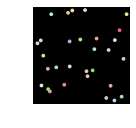

In [314]:
for _ in range(800):
    ps.draw()
    for _ in range(10):
        ps.sim()

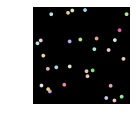

In [315]:
res = ps.draw()

In [316]:
res.shape

(128, 128, 3)

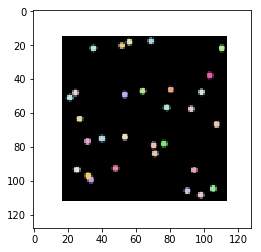

In [318]:
plt.imshow(res)

In [33]:
testy = [1,2,3,4,5]
list(itertools.combinations(testy, 2))

[(1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (2, 3),
 (2, 4),
 (2, 5),
 (3, 4),
 (3, 5),
 (4, 5)]

In [40]:
# you can get a high-resolution image as numpy array!!
plot_img_np = get_img_from_fig(fig)
(plot_img_np/255).shape

(720, 1080, 3)

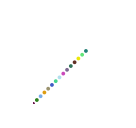

In [17]:
NUM = 15
dim_size = 128.0

ells = [Ellipse(xy=[5*i,5*i], width=5.0, height=5.0)
        for i in range(NUM)]

fig = plt.figure(0)

DPI = fig.get_dpi()
fig.set_size_inches(dim_size/float(DPI),dim_size/float(DPI))

ax = fig.add_subplot(111, aspect='equal')
for e in ells:
    ax.add_artist(e)
    e.set_clip_box(ax.bbox)
    e.set_alpha(1.0)
    e.set_facecolor(rnd.rand(3))

ax.set_xlim(0, dim_size)
ax.set_ylim(0, dim_size)
ax.axis('off')

plt.show()